# Text Analysis With Twitter Data

So far in this tutorial series we've discussed at length how to clean and process Twitter data. We've also introduced aspects of Natural Language Processing (NLP) such as word clouds and counting statistics. In this notebook, we will construct a topic model using **word vectors**, **word embeddings** and **K-means**. You will discover how to identify the topics that you're interested in analyzing. This model will have applications in the identification of groups of users for targeted advertising, or as a tool to quickly find relevant tweets to help quantify potential demand for a product/service. 



## Goals
1. Turn our tweets into "tweet" vectors. 
2. Cluster those vectors to define topics.
3. Use this model to locate relevant topics and discuss how such a model may be used for market research or advertising.

## Important Note

This analysis considers only tweets which were sent with location from Alberta, so things that "trend" in this data set may be different from things that trend on Twitter proper. **As well, we are missing tweets which did not have a location tag.**

More importantly - the analysis below is strongest when considering topics that don't yield well to key words. For example, political themes, food, and sports tend to work well with the following analysis as the language surrounding those ideas is _variable_ enough that a key word search may not work, but _consistent_ enough that the language used to describe those things is similar. Where this analysis _will not_ perform well is in cases where a keyword search would be best. For example, if you're looking for tweets concerning shoes, a keyword of shoes/brands will work better than the analysis we're about to do. However, if you're searching for something more abstract like fashion, the analysis we will walk through in this notebook may perform better than a simple keywords search. 


# Preliminaries 
 In this first section, we have two main concepts to cover: Word vectors and word embeddings. The introduction into k-means clustering will be saved for the relevant section.

## Word vectors

A word vector is the conversion of a word into a sparse, 'one-hot' coded vector. Each word contained within the selected tweets is mapped to a unique vector with only a single non-zero element. For example, the word "karate" may appear as 

\begin{equation}
\mbox{Karate} = 
\begin{pmatrix}
0 \\
\vdots \\
1 \\
\vdots \\
0
\end{pmatrix}.
\end{equation}

Here, it is represented as a _unique_ and _sparse_ vector containing a single non-zero entry. The size of each word vector is $N$, where $N$ is the number of words in our vocabulary. 

## Sentence Vectors

A sentence vector is simply  the word vector representation of sentence or in our case, a tweet. For example, the sentence
``` 
wax on, wax off
```

is just the vector sum of our word vectors for each word, or
\begin{equation}
\vec{D}_1 = 2\vec{w}_1 + \vec{w}_2 + \vec{w_3}.
\end{equation}

Notice how the vector for `wax` was repeated in this particular example. What this tells you is that, in sentence vectors, **punctuation and the order words appear is not important**. The vector representation of a sentence is the same. For example, the sentences

```
Turning words to math? That is lunacy! Why would you do that? 
```
and
```
Turning that math to words is lunacy! Why would you do that?
```

would have an identical _vector_ representation, even though they different sentences. 

## Word Embeddings 

On their own, word vectors are often too large and sparse to be particularly useful. More importantly, because word vectors are linearly independent (no combination of word vectors can be used to make a different word vector) understanding similarities between words and sentences is impossible. How do we transform these vectors into a form that can be used to understand linguistic similarities? 

What we need to do is develop our word embeddings - a new set of vectors that can relate words and sentences based on their similarities. In this case, we're going to use what's known as a "Neural Embedding", or word embeddings that are a result of a neural network trained on text data. In most applications, a fully connected shallow neural network (a neural network with only a single hidden layer) is used. The resulting parameter weights of the neural network define our _word embeddings_ or,  a series of **dense** vectors that represent the similarities between words. For this example, we will be using a set of pre-trained word embeddings available [in this github repository](https://github.com/eyaler/word2vec-slim/blob/master/GoogleNews-vectors-negative300-SLIM.bin.gz). This is a small version of word embeddings resulting from training on Google News, and has a vocabulary of about 300,000 words. 

Understanding how these word embeddings came about is not necessary. However, for those interested in learning more, you can use the drop-down menus below to find out how the neural network is used to create word embeddings. The first drop-down is very high level, and the next two are quite technical. 

---
<br> 
## Would you like to know more? 
<details>
<summary> Click here to learn about the idea of a word embedding </summary>
<br>
<h2> Word2Vec Word Embeddings </h2>
 
This section covers the basics of the model known as `word2vec` using what is known as the Continuous Bag Of Words (CBOW) model. In the CBOW model, our task is to predict "missing" words. For example, if we had the sentence 
```
I sure do love learning about word embeddings! 
```

To train our network, we would remove a single word from the sentence above, say "learning". We would then try to predict the word "learning" given an input of the other words in the sentence. Schematically this is represented below: 

![scheme](images/wor2vecschem.png)

In this case, we take the input context - the other words in our original sentence, and use them to predict the word that we've removed.  As words can exist in multiple contexts (among different sets of input words), this model can discover how different words are related to each other - with enough data we'll understand the "relationships" between words. What is nice about this model is that we have a massive _labeled_ data set for free!

 At face value, this neural network doesn't sound like it's particularly useful - all it is doing is predicting one word based on some words we've given to it as input. We can't even use that outside of the texts we've given it. How is it useful for understanding language? What we're trying to get from the training process is a set of internal parameters that relate our one-hot encoded vector to _all the other_ one-hot encoded vectors. The closer these vectors of internal parameters are, the more similar words are to each other. In the case of word embeddings, the network we use to create them is _only_ useful in terms of the weights it optimizes - not the output it produces.

What this means is that we will have word embeddings that represent the contextual similarities between words. Instead of using our simple one hot encoded vectors, we will now possess a vector formalism that can be used to understand things such as word similarity, and expand those to things like sentence and document similarity. 

---

## Would you like to know more? 
<details>
<summary> Click here to learn more about the neural network and the mathematics </summary>
<br>
<h2> Word2vec neural network and mathematics </h2>

The `word2vec` neural network appears most often as the following schematic

> ![word2vec](images/word2vec.png)
> 
> Image source: https://arxiv.org/pdf/1411.2738.pdf

A brief note on notation: bold quantities will represent both vectors and matrices, however matrices will be capitalized. In the image above, our input layer takes a word vector $\mathbf{x}$, which is the sentence vector with our target word removed (this vector is referred to as the "context"), and $\mathbf{y}$ is the one-hot word encoded vector that we removed from our sentence vector that we're trying to predict. These vectors are both of length $V$, the number of words in our vocabulary. 

We also have $N$ neurons in a hidden layer of $\mathbf{h}$, and two weight matricies $\mathbf{W}$ and $\mathbf{W^\prime}$. Here, $\mathbf{W}$ is a $V \times N$ matrix, and $\mathbf{W^\prime}$ is a $N \times V$ matrix. Notice how the number of hidden neurons defines the size of our hidden parameter matrices. 

## Forward Propagation 

Given the schematic above, we see that the values the hidden layer's output is defined as 
$$
\begin{equation}
\tag{1}
\label{eq:h}
\mathbf{h} = \mathbf{W} \mathbf{x} = \frac{1}{C} \mathbf{W} \cdot \left(\sum_{i=1}^C \mathbf{x}_i \right).
\end{equation}
$$
Where the vector $\mathbf{x}$ in \ref{eq:h} is our sentence vector which is simply the average of all the word vectors that make up the sentence. You may have noticed that in `word2vec` **the hidden layer has no activation function**. 

Now, the next step is to compute the **inputs** to each node on the outer layer, which we will define as $u$. For the $j^{th}$ output node we have
$$
\begin{equation} 
u_j = {\mathbf{v}^\prime_{\mathbf{W}_j}}^T \cdot \mathbf{h} .
\end{equation}
$$
Where ${\mathbf{v}^\prime_{\mathbf{W}_j}}$ is the $j^{th}$ column of the output matrix $\mathbf{W}^\prime$. Finally, we then compute the elements of the output (one-hot encoded) vector $\mathbf{y}$ as a soft-max distribution which can be thought of as the 'activation' function of this network, namely

$$
\begin{equation}
\tag{2}
\label{eq:yi}
y_j  = p(w_{y_j} | w_1, ..., w_C) = \frac{\exp(u_{y_j})}{\sum_{i=1}^V \exp(u_i) }.
\end{equation}
$$

Where the subscript $y_j$ means "the index of the $j^{th}$ output of $\mathbf{y}$. Now we have a definition of our word embeddings, namely:

$$
\begin{equation}
y(\mbox{word}) = \mbox{argmax} \frac{\exp(u_{y_j})}{\sum_{i=1}^V \exp(u_i) } = u_{y_j = index(\mbox{word})} = {\mathbf{v}^\prime_{\mathbf{W}_{j = index(\mbox{word})}}}^T \cdot \mathbf{h} .
\end{equation}
$$

Where we have switched to a more obvious notation, but less clear for derivations.  

As once our neural network is fully trained, we will have $V$ _word embeddings_ of size $N$, the size of our hidden layer. This is because we will now have a mapping from our one-hot encoded output vectors of a specific word to the specific _word embedding_ $u_j$ from equation \ref{eq:yi}. Indeed, the index $j$ where $\mathbf{y}$ is maximal will represent the column of the matrix $\mathbf{u}$ which represents the embedding of the output word $\mathbf{y}$

---

<details>
<summary> Click here to learn about `word2vec back propagation </summary>
<br>
<h2> Finding the weights of the neural network  </h2>



### Learning $\mathbf{W}$ and $\mathbf{W}^\prime$
As the training weights define our word embeddings, it is important to discuss how the randomly initialized weights get updated to effectively represent our word embeddings. 

### Updating $\mathbf{W^\prime}$
As with any neural network, the first step is to define our loss function, in this case we want to maximize the conditional probability (log likelihood) of our output word vector $\mathbf{y}$ given our input context sentence vector $\mathbf{x}$. So, for our first matrix $\mathbf{W^\prime}$ is defined as 
$$
\begin{align}
E & = - \ln p(\mathbf{y_*} | \mathbf{x}) \\
  & = -\ln \left(  \frac{\exp(u_j)}{\sum_{i=1}^V \exp(u_i) }\right) \\
  & = -u_* + \ln \sum_{i=1}^V \exp{u_i} \\
  & = -{\mathbf{v}_{\mathbf{w_O}}}^T \cdot \mathbf{h} + \ln \sum_{i=1}^V \exp({\mathbf{v}_{\mathbf{w}_i}}^T \cdot \mathbf{h}).
\end{align}  
$$
Where the $*$ subscript on $u_*$ is to indicate the index of the actual output word (our target), and $\mathbf{v}_\mathbf{w_O}$ is our output word embedding. Now, let's write out our derivatives explicitly for back propagation. First up,
$$
\begin{align}
\frac{\partial E}{\partial u_j} & = \frac{\partial}{\partial u_j} \left( -u_* + \ln \sum_{i=1}^V \exp{u_i} \right) \\
& = -\delta_{j,*} + \frac{\partial}{\partial u_j}\ln \sum_{i=1}^V \exp{u_i} \\
& = -\delta_{j,*} + \frac{1}{\sum_{i=1}^V \exp{u_i} }  \frac{\partial}{\partial u_j}\sum_{i=1}^V \exp{u_i} \\
& = -\delta_{j,*} + \frac{\exp(u_j)}{\sum_{i=1}^V \exp(u_i) } \\
& = y_i - \delta_{j,*},
\end{align}
$$
where $\delta_{j,*}$ is the Kronecker delta defined as 
$$
\begin{equation}
\delta_{j, *} =
\begin{cases}
        1, &         \text{if } j=*,\\
        0, &         \text{if } j\neq *.
\end{cases}
\end{equation}.
$$

Now that we have the derivative of our loss function with respect to the input to the $j^{th}$ node of our output layer $u_j$, we can also calculate the partial derivative with respect to the output weight $w^\prime_{i,j}$ via the chain rule

\begin{align}
\frac{\partial E}{\partial w^\prime_{i,j}} & =\frac{\partial E}{\partial u_j} \frac{\partial u_j}{\partial w^\prime_{i,j}} \\
& = (y_j - \delta_{j,*} ) \frac{\partial u_j}{\partial w^\prime_{i,j}} \\ 
& = (y_j - \delta_{j,*} ) \cdot \frac{\partial}{\partial w^\prime_{i,j}}\left( {\mathbf{v}^\prime_{\mathbf{W}_j}}^T \cdot \mathbf{h} \right) \\
& = (y_j - \delta_{j,*} ) \cdot \frac{\partial}{\partial w^\prime_{i,j}}\left( \sum_k w_{k,j} h_k \right) \\
& = (y_j - \delta_{j,*} ) \cdot h_i.
\end{align}.=

Fantastic! Now we can define an update equation using gradient decent with learning rate $0 < \eta < 1 $ as

\begin{equation}
w_{i,j}^{\prime (new)} = w_{i,j}^{\prime (old)} - \eta (y_j - \delta_{j,*} ) \cdot h_i,
\end{equation}


or in vector notation 
\begin{equation}
\mathbf{v}_{\mathbf{w}_j}^{\prime(new)} =\mathbf{v}_{\mathbf{w}_j}^{\prime(old)} - \eta (y_j - \delta_{j,*} ) \cdot \mathbf{h}.
\end{equation}

Where recall that $\mathbf{v}_{\mathbf{w}_j}^{\prime}$ is the $j^{th}$ vector of our weight matrix $\mathbf{W}^\prime$

### Updating $\mathbf{W}$

We also have a similar equation for the input weights. Our first derivative will be taken with respect to an arbitrary hidden node $h_i$
$$
\begin{align} 
\frac{\partial E}{\partial h_i} &= \sum_{j=1}^V \frac{\partial E}{\partial u_j} \cdot \frac{\partial u_j}{\partial h_i} \\
& = \sum_{j=1}^V (y_j - \delta_{j, *} )\cdot \frac{\partial}{\partial h_i} \left( \sum_j w^\prime_{i,j} h_j \right) \\
& = \sum_{j=1}^V (y_j - \delta_{j, *}) \cdot w^\prime_{i,j} .
\end{align}
$$
Where the sum is a result of the hidden layer being fully connected. The next derivative is the derivative of our loss function with respect to an arbitrary weight $w_{k,i}$
$$
\begin{align}
\frac{\partial E}{\partial w_{k,i} } & = \frac{\partial E}{\partial h_i} \cdot \frac{\partial h_i}{\partial w_{k,i}} \\
& = \sum_{j=1}^V (y_j - \delta_{j, *} )\cdot w^\prime_{i,j} \cdot \frac{\partial}{\partial w_{k,i}}\left[ \frac{1}{C} \mathbf{W} \cdot \left(\sum_{l=1}^C \mathbf{x}_l \right) \right]\\ 
& = \frac{1}{C} \left( \mathbf{x} \cdot \sum_{j=1}^V (y_j - \delta_{j, *} )\right) \cdot \frac{1}{C} \cdot x_k \\
& \Rightarrow \frac{1}{C} (\mathbf{x} \cdot EH) ,
\end{align}
$$
where 
$$
\begin{equation}
EH = \frac{1}{C} \left( \sum_{j=1}^V (y_j - \delta_{j, *} )\right),
\end{equation}
$$
and $\mathbf{x}$ becomes a vector after summation over $k$. In this case, the final gradient update equation for the input weight is 
$$
\begin{equation}
{\mathbf{v}_{\mathbf{w_{I,c}}}^{\prime}}^{(new)} = {\mathbf{v}_{\mathbf{w_{I,c}}}^{\prime}}^{(old)} - \frac{\eta}{C} EH.
\end{equation}
$$

## Stop!

Before you continue, please run the cell below.

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

!pip install pandas --upgrade --user
!pip install gensim --upgrade --user 

restartkernel()

Requirement already up-to-date: pandas in /home/jupyter/.local/lib/python3.6/site-packages (0.24.1)
Requirement already up-to-date: gensim in /home/jupyter/.local/lib/python3.6/site-packages (3.7.1)


## Downloading Tweets and Word Embeddings

In the cell below, we're downloading our cleaned tweets once again from the Rapid Access Cloud and putting them into a data frame. We also define our `model`, which is our pre-determined word embeddings that we can use to understand word similarity mathematically. 

**Note** This first cell may take a few moments to run as it's downloading ~ a 300 MB file to your hub account. 

In [2]:
import gensim
import urllib.request
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np 
from numpy.linalg import norm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# download word vectors
model_file = 'GoogleNews-vectors-negative300-SLIM.bin'
try:
    model = gensim.models.KeyedVectors.load_word2vec_format(model_file, binary=True)
except:   
    model_url = "https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_233e84cd313945c992b4b585f7b9125d/geeky-summit/GoogleNews-vectors-negative300-SLIM.bin"
    urllib.request.urlretrieve(model_url, model_file)
    model = gensim.models.KeyedVectors.load_word2vec_format(model_file, binary=True)
# Load pretrained model 


# download tweets
file_name="alberta_tweets_cleaned_feb_25.csv"
try: 
    df = pd.read_csv(file_name,parse_dates=['created_at_date']) 
except:
    target_url="https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_233e84cd313945c992b4b585f7b9125d/geeky-summit/alberta_tweets_cleaned_feb_25.csv"
    urllib.request.urlretrieve(target_url, file_name)
    df = pd.read_csv(file_name,parse_dates=['created_at_date']) 

# Convert to mountain standard time 
df.created_at_date= df.created_at_date.dt.tz_convert('MST')
df.head(2)

,created_at_date,hashtags_string,user_string,user_location,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned
0,2019-02-25 11:41:39-07:00,,Mbone49ers,Canada,NaN,NaN,Chris (Iron 3-0),LeafsBottleGang,@Mbone49ers He could make a pile in midget wre...,@Mbone49ers He could make a pile in midget wre...
1,2019-02-25 11:42:11-07:00,,AbsCoverage,"Calgary, AB",NaN,NaN,Dave,PrismaticHab,@AbsCoverage To play 4C?,@AbsCoverage To play 4C?


## Word Embedding Test Drive

Before we dive into the analysis, let's take a look at these "word embeddings" that we've now discussed at length. In this case, let's look at the embedding for the word "chocolate" 

In [3]:
# Remove the 'len' function and its enclosing parenthesis to look at the vector 
# directly if you're interested 
len(model.wv['chocolate'])

300

What we see here is that the word embedding is a 300 dimensional vector. This means two things:
1. The neural network these embeddings were taken from had a hidden layer of size 300
2. All words that this network was trained on (in this case approximately 300000) have been mapped down do 300 dimensional vectors, rather than their original sparse 300000 dimensional vectors. What a space savings!

Now that we have smaller vectors what can we do with them? As these are now "dense" vectors, we can start to do more exciting vector things with them. For example, we can calculate how "close" these vectors are to each other.  The idea being that the closer two word embeddings are, the more similar in meaning the words they represent are. In this case, vector similarity is calculated using the cosine distance between two vectors $\mathbf{A}$ and $\mathbf{B}$ is defined as 

\begin{equation}
\mbox{similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{||\mathbf{A}|| ||\mathbf{B}||} = \frac{\mathbf{A} \cdot \mathbf{B}}{\sqrt{\sum_i A_i^2} \sqrt{\sum_i B_i^2} } = \left[-1, 1\right]
\end{equation}

where this is simply the dot product of the normalized vectors. A similarity, often called a cosine distance, can take values between -1 and 1. Values of -1 imply that the vectors are anti-parallel, and in the context of word embeddings these words can be considered to be "opposite". A similarity of 0 implies the vectors are orthogonal, meaning that these words are not similar. Finally, a similarity score of 1 implies they're the same vector, or the same word. **The closer to one the similarity between two word embeddings are, the more similar the words are**.

Let's take that for a spin, first, lets see the most similar words to "chocolate" 

In [4]:
#here we're getting the 10 most similar words to the word "chocolate"
model.most_similar(positive=['chocolate'])

[('chocolates', 0.756921648979187),
 ('Chocolate', 0.7080809473991394),
 ('caramel', 0.6732012629508972),
 ('caramels', 0.6604535579681396),
 ('candy', 0.6375688314437866),
 ('candies', 0.6303936243057251),
 ('nougat', 0.6247628927230835),
 ('macaroons', 0.6229640245437622),
 ('Chocolates', 0.62019282579422),
 ('choco', 0.6129624843597412)]

In the output above, what we see is the word as the first output, and the cosine similarity as the number reported. Feel free to try other words in the above example.

We can also add and subtract these word embeddings to discover how words may be related in more complex ways. For example we can return results like 

> Man is to King as woman is to ____ 

Where we would fill in the word "Queen" by hand. In terms of vectors, this is done as 

$$ \mathbf{V}(queen) = \mathbf{V}(king) - \mathbf{V}(man) + \mathbf{V}(woman) $$


Which can be done using our model below

In [5]:
model.most_similar(positive = ['breakfast','evening'], negative=['morning'])

[('dinner', 0.7749413251876831),
 ('brunch', 0.7472958564758301),
 ('supper', 0.6734399199485779),
 ('dinners', 0.6469027996063232),
 ('meal', 0.646113395690918),
 ('Dinner', 0.6403425335884094),
 ('Brunch', 0.6256618499755859),
 ('banquet', 0.6239930391311646),
 ('breakfasts', 0.6228103637695312),
 ('luncheon', 0.6138027310371399)]

Which, is exciting in the sense that now **anything we can do to a vector, we can now do with language**.

## Try it out 
See if you can add/subtract different combinations of words and discover the resultant word vector. Do the results make sense to you? 

In [6]:
# Enter words as a list like: ["word", "otherword"]
positive = ['winter', 'rain']
negative = ['snow']
model.most_similar(positive = positive, negative=negative)

[('summer', 0.5753494501113892),
 ('spring', 0.5676975250244141),
 ('rains', 0.5368232727050781),
 ('rainless', 0.5075832605361938),
 ('weather', 0.5059000849723816),
 ('springtime', 0.49698519706726074),
 ('summertime', 0.4959695041179657),
 ('winters', 0.49184170365333557),
 ('downpour', 0.48562049865722656),
 ('Unseasonal', 0.4797162711620331)]

## Preparing Tweets

Our goal now is to create "tweet" vectors by adding up and averaging all the word vectors in our tweets. Mathematically we're after something of the form 
\begin{equation}
\mathbf{V}_{tweet} = \frac{1}{N}\sum_{word}^N \mathbf{V}_{word}
\end{equation}
where $N$ is the number of words in our tweet. 

But first - we have to do what we always do: clean our tweets even more. The first step, as we've seen before is to remove stop words and turn our tweets into tokens. In this case, the reason we're removing stop words is because they don't add anything "meaningful" to our sentences, and if we keep them in we'll accidentally make tweets look more similar to each other than they are because they're cluttered with filler language! This is done below

In [7]:
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
stop_words.append('amp')
stop_words = set(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# We will only use some of the tweets for time constraints - subsetting will be done later
subset = df.copy()

# tokenization and punctuation removal
def sent_to_words(row):
    sentence = row.extended_tweet_cleaned
    return(gensim.utils.simple_preprocess(sentence,min_len=3))  

# Create a new "tokens" colmn with our sent_to_words function
subset['tokens'] = subset.apply(sent_to_words, axis=1)

# Wrapper function to clean all the text at once 
def tokens_to_lda(row):
    data_token = row.tokens
    tokens = [token for token in data_token if token not in stop_words]
    return tokens

## Now we create a 'lemma' column for our cleaned data!
subset['lemma'] = subset.apply(tokens_to_lda, axis=1)

## We are also removing all data where the tweet is less than four words long. 
subset = subset[subset['lemma'].apply(lambda x: len(x) > 3)]

print("Total Tweets to analyze after cleaning: ", len(subset))
subset.head(3)


Total Tweets to analyze after cleaning:  22553


,created_at_date,hashtags_string,user_string,user_location,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned,tokens,lemma
0,2019-02-25 11:41:39-07:00,,Mbone49ers,Canada,NaN,NaN,Chris (Iron 3-0),LeafsBottleGang,@Mbone49ers He could make a pile in midget wre...,@Mbone49ers He could make a pile in midget wre...,"[mbone, ers, could, make, pile, midget, wrestl...","[mbone, ers, could, make, pile, midget, wrestl..."
3,2019-02-25 11:44:41-07:00,,BloomTaxonomy,I mute with reckless abandon. #INTJ,NaN,NaN,Under the Radar,retail_recruit,@BloomTaxonomy Not at all...read the first par...,@BloomTaxonomy Not at all...read the first par...,"[bloomtaxonomy, not, all, read, the, first, pa...","[bloomtaxonomy, read, first, paragraph, unders..."
6,2019-02-25 11:45:14-07:00,,OccupyEnlighten RaniaKhalek BootsRiley,Canada,NaN,NaN,Taina,TainaRenee,"@OccupyEnlighten @RaniaKhalek @BootsRiley Yep,...","@OccupyEnlighten @RaniaKhalek @BootsRiley Yep,...","[occupyenlighten, raniakhalek, bootsriley, yep...","[occupyenlighten, raniakhalek, bootsriley, yep..."


In [9]:
subset[subset.screen_name=='jaonesix']

,created_at_date,hashtags_string,user_string,user_location,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned,tokens,lemma
2389,2019-02-25 22:16:49-07:00,,Tkachukyou,"Calgary, ab",NaN,NaN,Jonathan Anderson,jaonesix,@Tkachukyou Solar health. Game changer,@Tkachukyou Solar health. Game changer,"[tkachukyou, solar, health, game, changer]","[tkachukyou, solar, health, game, changer]"
12986,2019-02-28 16:29:56-07:00,FlyTheW,CubsSkipper Cubs,"Calgary, ab",NaN,NaN,Jonathan Anderson,jaonesix,@CubsSkipper And the best manager in the game....,@CubsSkipper And the best manager in the game....,"[cubsskipper, and, the, best, manager, the, ga...","[cubsskipper, best, manager, game, cubs, flythew]"
13059,2019-02-28 16:49:37-07:00,,jhump_13 Eddie_Shovan,"Calgary, ab",NaN,NaN,Jonathan Anderson,jaonesix,@jhump_13 @Eddie_Shovan Fancy shoes too,@jhump_13 @Eddie_Shovan Fancy shoes too,"[jhump_, eddie_shovan, fancy, shoes, too]","[jhump_, eddie_shovan, fancy, shoes]"
19177,2019-03-02 08:25:01-07:00,,THEONESTEVIEC CoachsCornerDC RonHNIC NHLCanes,"Calgary, ab",NaN,NaN,Jonathan Anderson,jaonesix,@THEONESTEVIEC @CoachsCornerDC @RonHNIC @NHLCa...,@THEONESTEVIEC @CoachsCornerDC @RonHNIC @NHLCa...,"[theonesteviec, coachscornerdc, ronhnic, nhlca...","[theonesteviec, coachscornerdc, ronhnic, nhlca..."
23656,2019-03-03 10:29:15-07:00,,sneller80 blazerhockey NHLFlames GeordieMacleod,"Calgary, ab",NaN,NaN,Jonathan Anderson,jaonesix,@sneller80 @blazerhockey @NHLFlames @GeordieMa...,@sneller80 @blazerhockey @NHLFlames @GeordieMa...,"[sneller, blazerhockey, nhlflames, geordiemacl...","[sneller, blazerhockey, nhlflames, geordiemacl..."
24108,2019-03-03 12:34:36-07:00,,khanhockey13,"Calgary, ab",NaN,NaN,Jonathan Anderson,jaonesix,@khanhockey13 Enough is enough. No more Smith ...,@khanhockey13 Enough is enough. No more Smith ...,"[khanhockey, enough, enough, more, smith, starts]","[khanhockey, enough, enough, smith, starts]"


## Finding "Tweet Vectors"

To find tweet vectors, we simply take the average of all the word vectors in our cleaned and processed tweets. This is done below. 

In [10]:

# Here we are making a list of all the words we have vectors for 
vocab = model.vocab.keys()

def tweet_vectorizer(tweet):
    vector = np.array([0 for i in range(300)])
    count = 0
    # Here we build our tweet vectors 
    for w in tweet:
        if w in vocab:
            count += 1
            vector = vector + np.array(model[w]) 
    if len(tweet) != 0:
        # Divide by the norm here so we can be lazy with a matrix multiplication later. 
        vector = vector / count
        vector = vector/norm(vector)
        
        
        return list(vector)
    else:
        # If no words in the tweet are in the model, we set it to zero
        # to ensure it will be opposite to all other word embeddings. 
        return [0 for i in range(300)]

# Actually call the function 
subset['vect'] = subset['lemma'].apply(tweet_vectorizer)
subset = subset.reset_index(drop=True)

# Here we truncate our set
#subset = subset[0:20000]
subset.tail(2)


,created_at_date,hashtags_string,user_string,user_location,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned,tokens,lemma,vect
22551,2019-03-04 10:22:51-07:00,,boehmerB gmbutts,"Calgary, Alberta",NaN,NaN,John Birmingham,JohnRBirmingham,"@boehmerB @gmbutts ""WWF’s international networ...","@boehmerB @gmbutts ""WWF’s international networ...","[boehmerb, gmbutts, wwf, international, networ...","[boehmerb, gmbutts, wwf, international, networ...","[-0.02876276025329898, -0.03952253498448477, 0..."
22552,2019-03-04 10:23:17-07:00,ABCommsForum,,Calgary,NaN,NaN,Natasha Cousin,ngleiser,Loved the tip to think of your mediums as a se...,Loved the tip to think of your mediums as a se...,"[loved, the, tip, think, your, mediums, search...","[loved, tip, think, mediums, search, engine, c...","[0.046865352788383545, 0.008118043164974142, -..."


## Finding Similar Tweets

We've now created our own "tweet" vectors using our pre-trained model, let's take a look and see how well it worked! First, try out the code below. You will have to write a little code first however! But, note in the cell below that the matrix $\mathbf{A}$ is defined as 

\begin{equation}
A = 
\begin{pmatrix}
\begin{bmatrix}
& & V_{\mbox{tweet } 1} & & & 
\end{bmatrix} \\
 \begin{matrix}
 & & \dots & & & 
\end{matrix} \\
 \begin{matrix}
 & & \dots & & & 
\end{matrix} \\
\begin{bmatrix}
& & V_{\mbox{tweet } N} & & & 
\end{bmatrix}
\end{pmatrix},
\end{equation}


 which is the matrix of all our tweet vectors, where each row is an individual tweet vector. Keep in mind we've also **already normalized all our tweet vectors**. So you don't have to worry about normalizing things again when you're calculating your similarity scores. 



In [11]:
# Create the matrix A
A = np.array(subset['vect'].tolist())
# If any entries are not a number NaN - convert them to zero
A[np.isnan(A)] = 0
print(A.shape)

(22553, 300)


#### Hint
In python, matrix multiplication is done with the `@` symbol. For example, the matrix multiplication $\mathbf{A \cdot x} = \mathbf{b}$ would be written in python as
```python
b = A @ x
```

In [12]:
# index of the tweet we're interested in, feel free to change this. 
# Note, that it's currently set to the last tweet, so your choices must be < 19999
interest = 133

# this is the tweet vector at the index we've decided to use 
x = np.array(subset['vect'].iloc[interest])


similarity_scores = A @ x# YOUR CODE HERE

# This will find the top 5 highest similarites, then sort them bin descending order 
max_index = similarity_scores.argsort()[-5:][::-1]

# if you're interested in the _least_ similar tweets, try changing things with this
# min_index = np.argpartition(similarity_scores, 5)[:5]


print("="*90)
print("Note: The first most similar tweet will be the tweet itself")
print("Tweet we're looking for similarities to:\n\n",subset['extended_tweet_cleaned'].iloc[interest])
print("="*90)
print()
for index in max_index:
    print(subset['extended_tweet_cleaned'].iloc[index],"||" ,"index =", index,  "similarity score=", similarity_scores[index])
    print()
    

Note: The first most similar tweet will be the tweet itself
Tweet we're looking for similarities to:

 Woah!!! I want expecting this today!! pumpitup 

Woah!!! I want expecting this today!! pumpitup  || index = 133 similarity score= 0.9999999999999998

Going to @SkiLouise today with @atbfinancial 💃🏼💃🏼💃🏼 || index = 15998 similarity score= 0.7935885456418117

@mistysaid Next week is gonna be so bad... I'm glad I got my botox today. I hope it kicks in fast enough. || index = 17444 similarity score= 0.7651915525692354

Today 2:36 PM
Hi
Hey lo
Today 4:38 PMNot a good time right
And yes this is Jeff bro
Today 4:42 PM
whatvr
then
Just…  || index = 691 similarity score= 0.7457539552775869

@kelitos_way yeah i didn't take it down yet 💯wil here today maybe if i get arou🙃🤣😆nd to it || index = 3097 similarity score= 0.7412525852220502



Feel free to search for different tweets which are similar. There will be some cases where it works quite well, and some cases where... well it probably didn't do the best job. Unfortunately, that's just the nature of twitter - this model can't account for things like spelling mistakes, emojis, and the typical non-sense that one might expect from within 20000 tweets. But, there will certainly be cases where you may be surprised at how well this method works from nothing but a simple matrix-vector dot product!

# K-means clustering as a topic model

As we mentioned earlier, as our tweets are now vectors, we are able to do "vector things" with them. One such "vector thing" is the ability to cluster vectors together based on similarity. This means that we can group similar vectors together and create multiple groups of similar vectors, in our case, tweets that contain similar language used. Each of these groups may represent a topic, and we can use these topics to better understand what people are discussing in these tweets - and if we can use that to better understand something of interest to us. 

## K-means

K-means is an algorithm that will group similar vectors (data) around $k$ centers, where the number of centers $k$ is determined in advance. Essentially, K-means will sort our vectors based on similarity, and group similar tweets together for us. K-means clustering is deceptively simple and can be described as the following iterative steps

1. Initialize by defining $k$ centroids _randomly_. With our tweets, these centroids will be 300 dimensional vectors.
2. Repeat the following until changes between iterations are minimal
      - Assign each data point (our tweet vectors) to the centroid to which it is closest to. 
      - Recalculate the positions of the centers based on the mean of the data points that were assigned to it.
    
If you're interested in learning more about K-means clustering, expand the drop down below, however an intimate understanding of the algorithm is not required to complete the rest of this tutorial.

---
<details>
<summary> Click here to learn more about the k-means algorithm </summary>
<br>

## The K-means clustering algorithm
In this case, we define a set of centers 
\begin{equation}
means =\left\{\mu_i\right\} |_{i=0}^k 
\end{equation} 
where $k>1$, the number of centers you'd like to look for (and in our case, the number of topics). 

Once we've decided on the number of topics, the objective of k-means is to find 

\begin{equation}
\tag{3}
\label{eq:kmean}
f(\mathbf{\mu};\mathbf{x}) =\min \sum_{j \in k} \sum_{i \in S_j} ||x_i - \mu_j||^2
\end{equation}

where the sets $S_j$ are the sets of points which are closest to center $\mu_j$. In order to find the appropriate means $\mu_j$ an iterative procedure is used. Specifically, we have the following algorithm. 

---
**initialize** $\mu_1, ..., \mu_k \rightarrow$ our randomly chosen centers <br>

**While** objective function \ref{eq:kmean} improves **do**<br>
&nbsp;&nbsp;&nbsp;&nbsp; **Assign** each $\mathbf{x}_i$ to a set $S_1,.., S_k$ based on euclidean distance from each center $\mu_j$: <br>
  &nbsp;&nbsp;&nbsp;&nbsp; **for** $i$ **in range(N)** $\leftarrow$ $N =$Number of data points <br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $j =  \mbox{argmin} ||x_i - \mu_k||^2$ <br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; add $\mathbf{x}_j$ to $S_j$ <br>
  &nbsp;&nbsp;&nbsp;&nbsp; **end for** <br>
  &nbsp;&nbsp;&nbsp;&nbsp; **for** $j = 1,...,k$: <br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\mu_j$ =$ \frac{1}{\mbox{len}(S_j)}\sum_{i \in S_j} x_i$ $\leftarrow$ calculate new centers<br>
  &nbsp;&nbsp;&nbsp;&nbsp;**end for** <br>
**end while**
 


Once that algorithm has converged, we will have a set of $k$ optimize means, and each data point will be assigned to the mean that is closest to it. 
    
    
    





## Choosing $k$, the number of clusters

As the number of clusters $k$ is required for our algorithm, how do we decide on how many clusters we should have? Well, this is a case where Data Science becomes more art than science. In this case, we will opt for an "elbow plot", or a plot where we calculate a metric for how well our topic model performs, and the "ideal" number of topics is where further iterations of the model stop improving. This is done in the cell block below. However, it can take a moment to run, so it is currently commented out. If you'd like to generate your own figure, certainly feel free but note it may take 15-20 minutes to calculate. 

In [ ]:
#from IPython.display import clear_output
#from sklearn.cluster import MiniBatchKMeans
#inert = []
#for i in range(2,225):
#     clear_output(wait=True)
#     print(i)
#     # here we're simply calculating more clusters each iteration. 
#     intertia_test = MiniBatchKMeans(init='k-means++',
#                                     n_clusters=i+1, 
#                                     random_state=5, 
#                                     init_size=3*i, 
#                                     batch_size=1000)
#     # This is where we fit our data to our k-means topics 
#     intertia_test.fit(A)
#     # We also save what's known as the model inertia - which is related to how far away each data point 
#     # is from a given topic. A smaller inertia indicates a "better" model. 
#     inert.append(intertia_test.inertia_)

#plt.figure(figsize=(12,8))   
#plt.xlabel("Number of clusters", size = 16)
#plt.ylabel("Momentum (smaller is better)", size=16)
#plt.plot(inert)
#plt.show()


If you run the code cell above, you should get a plot which looks like the one below 

> ![elbow plot](images/momentum.png)
> Figure: This figure is the "elbow" plot which will aide us in choosing the best number of topics

From the figure above, we see that the "momentum" of our plot, or the objective function, gets smaller and smaller as we add more and more topics. In this case, the "elbow" is at approximately 77 topics, and for many applications, that may be the number of topics you wish to choose. However, for our analysis we're going to choose 175 as we have reason to believe that out of ~20000 tweets, we probably have more than 77 topics at a given time. This is done below, however, feel free to experiment with the `n_clusters` parameter in the cell below and experiment with different topic models. Each model typically only takes a second or two to complete. 

In [13]:

from sklearn.cluster import MiniBatchKMeans
# Define the k-means model

# Experiment with other topic numbers! Change the number of clusters to anything between 2 and 500 
# ( you could choose more than 500, but it may take a long time to compute!)
clusters = 175
kmeans_model = MiniBatchKMeans(init='k-means++',
                                    n_clusters=clusters, 
                                    random_state=5, 
                                    init_size=3*clusters, 
                                    batch_size=1000)
# Pass it the matrix A, or all out tweets!
kmeans_model.fit(A)
cluster_labels  = kmeans_model.labels_
print("k-means clustering complete!")


k-means clustering complete!


## Testing The Topic Model 

Now that we've created a topic model, it might be nice to test how well it did! In this case, let's see how k-means clustered tweets from an obvious source. We're lucky in that there is a twitter account `@311Calgary` which tweets out things like road reports, dead animal pick ups, traffic light fixes and so forth. The idea here however is that many of these tweets are very formulaic, and if our topic model performed admirably, these tweets should be clustered well. 

In [ ]:
# grab the index of 311calgary tweets 
tweets311 =subset[subset.screen_name == '311calgary'].index.tolist()
places=[]
for labels in tweets311:
    # Here cluster_labels[labels] returns the topic that each tweet has been assigned to 
    places.append(cluster_labels[labels])
# set removes duplicates
print(set(places))


Where the numbers above are all the topics where the tweets from `@311calgary` got sorted. Explore each topic and see how well you think our model did. Some topics (such as 92, the default below) seem to be very well sorted. However, as you explore see if you can find some exceptions - but also read further to see if you can understand _why_ something may have been grouped "incorrectly". 

In [14]:
# Change cluster_labels == NUM to view different topics 
itemindex = np.where(cluster_labels == 92)[0]
itemindex
c=0
for i in itemindex:
    c +=1 
    print(subset['extended_tweet_cleaned'].iloc[i])
    print()
print(c)


Closed Sign on Street/Lane/Sidewalk-Repair/Replace request at 950 MCPHERSON SQ NE  

Closed Sign on Street/Lane/Sidewalk-Repair/Replace request at 5565 CROWCHILD TR NW  Request… 

Closed Sign on Street/Lane/Sidewalk-Repair/Replace request at 720 CENTRE A ST NW  Duplicate… 

Closed Sign on Street/Lane/Sidewalk-Repair/Replace request at 147 CRANARCH TC SE  Request c… 

Closed Sidewalk - Walkway Repair request at 3350 17 AV SE  

Closed Sign on Street/Lane/Sidewalk-Repair/Replace request at 321 10 AV SW 

Opened Sign on Street/Lane/Sidewalk-Repair/Replace request via android at 170 INVERNESS PA SE… 

Closed Debris on Street/Sidewalk/Boulevard request at 3404 12 ST NE 

Opened Sign on Street/Lane/Sidewalk-Repair/Replace request via web at 7306 26 Ave SW  Pleas… 

Opened Sign on Street/Lane/Sidewalk-Repair/Replace request via android at 805 4 ST NE  No stopping.

Opened Sign on Street/Lane/Sidewalk-Repair/Replace request via iphone at 805 1 ST SW  Need… 

Closed Sign on Street/Lane/Sidewalk

However, if you view the topics that our 311 Calgary tweets got placed into - you'll notice that different kinds of reports got placed in their own topic automatically such as closed streetlight requests  and traffic signal timing inquiries . This was all done automatically - we did nothing to ensure that this happened. This is simply a result of the similar language used in each of the `311Calgary` having a similar vector representation, which makes them easy to cluster. 

# Finding Topics You Care About

From the above, you've probably noticed that we just have a bunch of numbers representing topics - we still have no idea what those topics actually are! Unfortunately, that's not something we can get away from, in any form of clustering it is still up to us, a human, to decide what the topic is actually about. However, we can "cheat" a little and add data to our data set which we feel represents a topic we're interested in, and use that to find a topic we care about.


What we're going to do next is create some "fake" data and see if we can find some topics about food and sports. How we're going to do this is insert our own tweets into the data, and re-run the topic model with these new tweets. Then, we'll simply see where our fake tweets ended up!

Before we get into it, remember that we're essentially adding custom word vectors - and the word vectors don't care about things like word order, grammar, or filler words. We essentially just need to do a **keyword search**. Let's take a look at how that's done below.

In [15]:
# Make a new data frame to not mess anything else up 
subset_with_discovery = df.copy()

# here are the sentences we're adding 
sentences = [
    "what should I eat for dinner i've got a craving for junk food",
    "hockey goal win score",
    "sports! winning! boy do I enjoy these atheletes",
    "job openning employment hiring",
    "celebrities oscars award oscar",
    "fashion clothes jewelry design",
    "entertainment social media",
    'movies theatre entertainment art music event',
    'music shows concert' 
]

# Insert a fake user so they're easy to find like the 311calgary tweets 
user = 'fake_tweets_for_analysis'

# Need to fill in the other data to the table, here we're just entering nothing 
empty = [np.nan for i in range(len(sentences))]
add = {
    'created_at_date': empty,
    'hashtags_string':empty,
    'user_string':empty,
    'user_location':empty,
    'longitude':empty,
    'latitude':empty,
    'name':empty,
    'screen_name':[user for i in range(len(sentences))],
    'extended_tweet':empty,
    'extended_tweet_cleaned':[sentences[i] for i in range(len(sentences))]
}
    
add = pd.DataFrame.from_dict(add)

# We also need to treat this data just like the original data! Nothing new here 
add['tokens'] = add.apply(sent_to_words, axis=1)
add['lemma'] = add.apply(tokens_to_lda, axis=1)

add['vect'] = add['lemma'].apply(tweet_vectorizer)
new_subset = pd.concat([subset, add]).reset_index(drop=True)

print("Total Tweets to analyze after cleaning: ", len(new_subset))
# This is to just look at our inserted fake tweets 
new_subset.tail(5)


Total Tweets to analyze after cleaning:  22562


,created_at_date,hashtags_string,user_string,user_location,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned,tokens,lemma,vect
22557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fake_tweets_for_analysis,NaN,celebrities oscars award oscar,"[celebrities, oscars, award, oscar]","[celebrities, oscars, award, oscar]","[-0.12803238032118866, 0.01927957653602527, -0..."
22558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fake_tweets_for_analysis,NaN,fashion clothes jewelry design,"[fashion, clothes, jewelry, design]","[fashion, clothes, jewelry, design]","[-0.0388518034473624, 0.024999793019031668, -0..."
22559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fake_tweets_for_analysis,NaN,entertainment social media,"[entertainment, social, media]","[entertainment, social, media]","[0.042089234555559, -0.03517614083314352, -0.1..."
22560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fake_tweets_for_analysis,NaN,movies theatre entertainment art music event,"[movies, theatre, entertainment, art, music, e...","[movies, theatre, entertainment, art, music, e...","[0.009989894133839421, -0.038939341491924934, ..."
22561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fake_tweets_for_analysis,NaN,music shows concert,"[music, shows, concert]","[music, shows, concert]","[0.04789635831975904, -0.02900591301371449, -0..."


Great! We've created our fake data and inserted it into our set, let's make a new kmeans model and see where those ended up! 

In [16]:

A = np.array(new_subset['vect'].tolist())
A[np.isnan(A)] = 0

kmeans_model = MiniBatchKMeans(init='k-means++',
                                    n_clusters=clusters, 
                                    random_state=5, 
                                    init_size=3*clusters, 
                                    batch_size=2000)
kmeans_model.fit(A)
cluster_labels  = kmeans_model.labels_

Same code as our 311Calgary tweets, lets' see where our nefarious fake tweets have landed in the topic model, and judge for ourselves how well they worked. 

In [17]:
places=[]
infultrators = new_subset[new_subset.screen_name == user].index.tolist()
for labels in infultrators:
    places.append(cluster_labels[labels])

tweets_clusters = pd.DataFrame(
    {'Sentence': sentences,
     'Cluster': places
    })

print("Our fake tweets of 'known' topic gave ended up in the following topics:\n", tweets_clusters)


Our fake tweets of 'known' topic gave ended up in the following topics:
                                             Sentence  Cluster
0  what should I eat for dinner i've got a cravin...       47
1                              hockey goal win score       29
2    sports! winning! boy do I enjoy these atheletes       59
3                     job openning employment hiring       17
4                     celebrities oscars award oscar       78
5                     fashion clothes jewelry design      114
6                         entertainment social media        5
7       movies theatre entertainment art music event        5
8                                music shows concert        5


# Let's look at where our "infiltration" tweets ended up 

Let's start with topic `29`, which is our sports topic and see how well it did. This is done below 

In [18]:
itemindex = np.where(cluster_labels== 29)[0]
itemindex
c=0
for i in itemindex:
    c +=1 
    print(new_subset['extended_tweet_cleaned'].iloc[i])
    print()
print(c)

Seems like it could Oscar Fatenberg. A Swedish defensemen who shoots LH. He has 2 goals and 1 assist this season wi… 

Wait, there could have been something last minute! Jason Zucker (Minnesota Wild) has 15 goals, 16 assists and 31 po… 

He is a LH, Left-winger. He entered the NHL in 2011-12 and has 112 goals and 91 assists in his career. He has 392 N… 

Lmao I took a nap and missed 4 goals 🤣

Oilers have 1 goal on 0 shots apparently 

Kapanen short handed goals is an evergreen mood 
LeafsForever 

habs are 2-6-0 in last 8....19 goals for 27 goals against....

How to psych out a shooter on the spot... by @CPLCavalryFC Keeper Niko Giantsopolous 👇😂☠️
CanPL 

@YahooFantasy Draisaitl’s goals aren’t populating FYI

19 gms left .. if Habs average a pt per game, they'll end up w/ 92pts.
Not enough, IMO  :(

goHabsGo

After first half @StAmbrose_CCSD storm is up by 7 points. 22-15 

Matthew Tkachuk scores sweet Goal calgaryFlames SICKMITTS

16:43 pass up the ice from 12stroher to 8fath who was

Arguably it did pretty well, certainly not all the tweets are about sports, but considering we were able to sort these into 200 topics in a few seconds, it did pretty good!

### For you
Try adding your own key word searches into the model and re running it. Do the topics your fake tweets end up in make sense? What do you think you could do to make things a little better? Also try things like a different number of topics - how do your results chance? 

## Next Steps

From here you've got a great baseline to start things like market research. If you find a large group of tweets relevant to either your product or business, you can use those to understand how people are discussing those issues publicly. Either from a sentiment analysis to understand how people feel, as market research to understand what people seem to need, or to discover which users to target for advertising purposes. Of course, this is a minimal model and may not be perfect for answering those questions explicitly. However, understanding this model can act as a solid basis to iterate to more complex models which may see greater success in understanding your business problems via twitter text analysis. 

## Epilogue: Finding users in your topic 

Suppose you've found a group of tweets around a topic of interest for you or your business. Now, you might like to either contact those users directly, or target ads at them. How do we go about that? Well, our first step is to add those topic labels to our data frame. This is done below. 

In [19]:
new_subset['topic'] = cluster_labels.tolist()
new_subset.head(2)

,created_at_date,hashtags_string,user_string,user_location,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned,tokens,lemma,vect,topic
0,2019-02-25 11:41:39-07:00,,Mbone49ers,Canada,NaN,NaN,Chris (Iron 3-0),LeafsBottleGang,@Mbone49ers He could make a pile in midget wre...,@Mbone49ers He could make a pile in midget wre...,"[mbone, ers, could, make, pile, midget, wrestl...","[mbone, ers, could, make, pile, midget, wrestl...","[0.030589931462928942, 0.054521879043555425, 0...",20
1,2019-02-25 11:44:41-07:00,,BloomTaxonomy,I mute with reckless abandon. #INTJ,NaN,NaN,Under the Radar,retail_recruit,@BloomTaxonomy Not at all...read the first par...,@BloomTaxonomy Not at all...read the first par...,"[bloomtaxonomy, not, all, read, the, first, pa...","[bloomtaxonomy, read, first, paragraph, unders...","[0.08599190740822522, -0.03382689938351259, 0....",151


Now, suppose for example you're interested in targeting sports fans, which is topics number `29` and `59` in our model. We can find these users using some simple `pandas` commands 

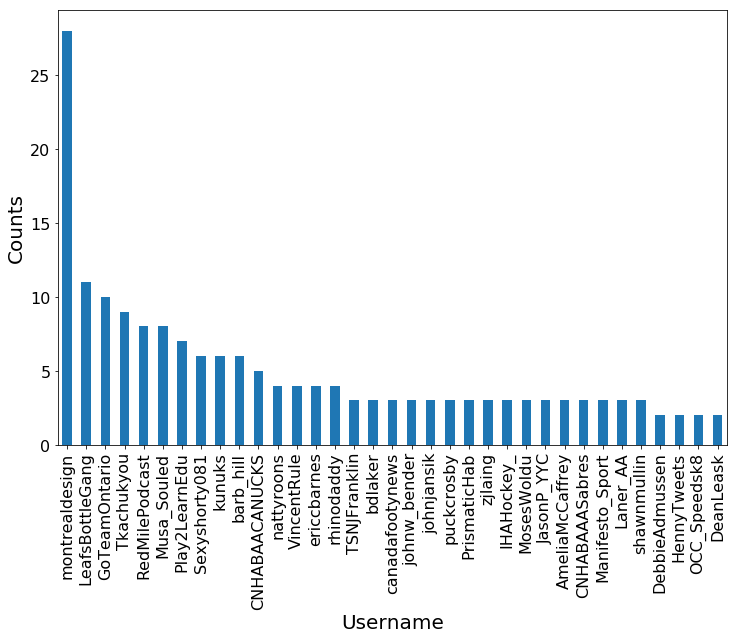

In [21]:
# Filter by topic, where the number in subset.topic == NUMBER is the topic of interest
# Note: the " | " means "Or"

sports = new_subset[(new_subset.topic == 29) | (new_subset.topic == 59)].copy()
# Count how many times each user tweets 
counted = sports.groupby(['screen_name'])['screen_name'].count().sort_values(ascending=False)

ax = counted[0:35].plot(kind = 'bar', figsize= (12,8))
ax.set_ylabel("Counts", size = 20)
ax.set_xlabel("Username", size = 20)
ax.tick_params(axis='both', which='major', labelsize=16)

Where in the plot above we've only plotted the first 35 user with the most tweets in topic 8, a topic we have decided is a sports topic. One caveat to Twitter is when one user has significantly more Tweets in a topic, that usually means one of two things:

1. This user is passionate about the topic their tweets got sorted into
2. This user is a corporate account, and what we're seeing are ads

In this case, let's take a look at `montrealdesign` to make sure that this is actually a user, and not an obvious ad bot. We view the first five tweets below. 

In [22]:
for tweets in sports[sports.screen_name == 'montrealdesign'].extended_tweet.tolist()[0:5]:
    print(tweets)
    print()

Good pickup for #Preds .. IMO, Granlund is the better hockey player.

#VegasBorn seriously improved their hockey team .. Wow.#Stone

Weezer is a horrible rock band .. if i play them at the Club, ppl throw stuff at me .. and it ain't money. :)@joeyalfieri

As a #Habs fan, we're not allowed to talk about:- Price's play- Weber's play- Drouin's play- Julien's coaching… 

19 gms left .. if #Habs average a pt per game, they'll end up w/ 92pts.Not enough, IMO  :(#goHabsGo



Where in this case this just looks like it might be someone who enjoys tweeting about sports! Feel free to change the above 2 code cells to see the popular users in your specific topic! 

In [23]:
# Here we're seeing who tweets most in this topic 
s=sports.groupby(['screen_name'])['screen_name'].count().sort_values(ascending=False)

# This is a potential list of users who we may want to target 
s[s>1].index.to_list()


['montrealdesign',
 'LeafsBottleGang',
 'GoTeamOntario',
 'Tkachukyou',
 'RedMilePodcast',
 'Musa_Souled',
 'Play2LearnEdu',
 'Sexyshorty081',
 'kunuks',
 'barb_hill',
 'CNHABAACANUCKS',
 'nattyroons',
 'VincentRule',
 'ericcbarnes',
 'rhinodaddy',
 'TSNJFranklin',
 'bdlaker',
 'canadafootynews',
 'johnw_bender',
 'johnjansik',
 'puckcrosby',
 'PrismaticHab',
 'zjlaing',
 'IHAHockey_',
 'MosesWoldu',
 'JasonP_YYC',
 'AmeliaMcCaffrey',
 'CNHABAAASabres',
 'Manifesto_Sport',
 'Laner_AA',
 'shawnmullin',
 'DebbieAdmussen',
 'HennyTweets',
 'OCC_Speedsk8',
 'DeanLeask',
 'YMCA_Calgary',
 'doyoueventrade1',
 'ALLSAINTSccsd',
 'fake_tweets_for_analysis',
 'charlton1016',
 'JSBlades',
 'IanIdeaman7',
 'TriAlberta',
 'SeanOReilly1969',
 'LethMAAACanes',
 'Roscopeko79',
 'RTF666',
 'MannyTerrebonne',
 'MarcMnM',
 'heididelf',
 'PennyWerthner',
 'gpscalgary',
 '1MYK3L',
 'ronalie_canada',
 'tommywheeldonjr',
 'seacmidgetaaa15',
 'scoot174',
 'sam_corea',
 'jaonesix',
 'kelownaolde']